In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

In [1]:
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3


Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-learn-0.13.0:
  Successfully uninstalled imbalanced-learn-0.13.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 22.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
#Import Libraries

import numpy as np
import pandas as pd
import pickle
from scipy import sparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load Features and Labels

# Load sparse features
X = np.load("/kaggle/input/model-train/X_features.npy")
y = np.load("/kaggle/input/model-train/y_labels.npy")

print("Features Loaded Successfully!")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Features Loaded Successfully!
Shape of X: (22658, 3005)
Shape of y: (22658,)


In [5]:

# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])


Training Samples: 18126
Testing Samples: 4532


In [6]:

# Balance Classes with SMOTE

smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original Training Shape:", X_train.shape)
print("After SMOTE:", X_train_res.shape)


Original Training Shape: (18126, 3005)
After SMOTE: (30814, 3005)


In [7]:
# Logistic Regression (Baseline)

lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

f1_lr = f1_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_pred_lr)
print("Logistic Regression -> F1:", round(f1_lr, 3), "ROC-AUC:", round(roc_lr, 3))


Logistic Regression -> F1: 0.438 ROC-AUC: 0.645


In [8]:
#Random Forest Classifier

rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_pred_rf)
print("Random Forest -> F1:", round(f1_rf, 3), "ROC-AUC:", round(roc_rf, 3))


Random Forest -> F1: 0.56 ROC-AUC: 0.708


In [9]:
# XGBoost Classifier
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    tree_method='gpu_hist',  # GPU acceleration
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("XGBoost -> F1:", round(f1_xgb, 3), "ROC-AUC:", round(roc_xgb, 3))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:03:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:03:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:03:07] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


XGBoost -> F1: 0.555 ROC-AUC: 0.773


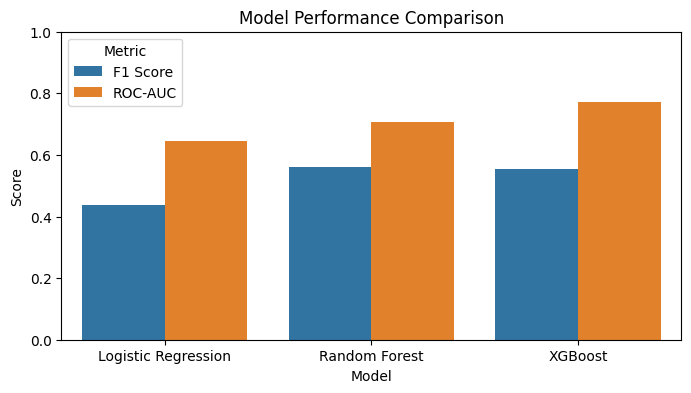

,Model,F1 Score,ROC-AUC
1,Random Forest,0.560450,0.708430
2,XGBoost,0.554762,0.773332
0,Logistic Regression,0.437500,0.645326


In [10]:
# Compare Models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'F1 Score': [f1_lr, f1_rf, f1_xgb],
    'ROC-AUC': [roc_lr, roc_rf, roc_xgb]
})

plt.figure(figsize=(8,4))
sns.barplot(data=results.melt(id_vars='Model', var_name='Metric', value_name='Score'),
            x='Model', y='Score', hue='Metric')
plt.title("Model Performance Comparison")
plt.ylim(0,1)
plt.show()

results.sort_values(by='F1 Score', ascending=False)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      3852
           1       0.47      0.69      0.55       680

    accuracy                           0.83      4532
   macro avg       0.70      0.77      0.73      4532
weighted avg       0.87      0.83      0.85      4532



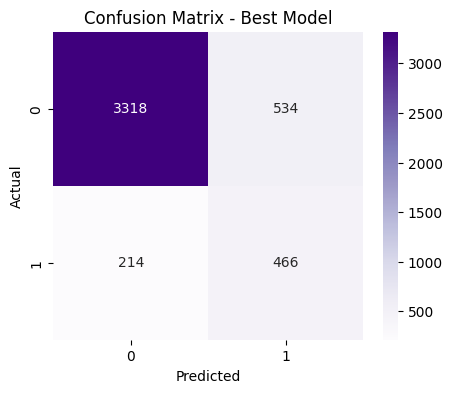

In [11]:
# Classification Report

best_model = xgb  

y_pred_best = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
# Save Model

with open("/kaggle/working/trend_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Best Model saved successfully as trend_model.pkl")


✅ Best Model saved successfully as trend_model.pkl
